In [ ]:
!pip install torch matplotlib 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 734.5/734.5 kB 1.6 MB/s eta 0:00:00m-:--:--
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.25.2-py3-none-any.whl size=852394 sha256=1f2f49109b7bbc534f54bc3a80a5796ffb635ee9b40188fc03c281f8e53c9f03
  Stored in directory: /home/ds/.cache/pip/wheels/78/95/2c/ee47a8d43fda6a851e340e77e27cf75b49ff4ce2d1540c0e80
Successfully built gym


In [26]:
!pip install gymnasium==1.1.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 377.9 kB/s eta 0:00:00a 0:00:01


The open-source Gym software package from OpenAI, a Python library that simulates different environments and games, which can be solved using Reinforcement learning. 

Use OpenAI Gym to create two instances (one for training and another for testing) of the CartPole environment:

In [2]:
from tqdm import tqdm
import gymnasium as gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import rl_utils
from IPython.display import clear_output
import time

In [3]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)


class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)


class PPO:
    ''' PPO算法,采用截断方式 '''
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 lmbda, epochs, eps, gamma, device):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs  # 一条序列的数据用来训练轮数
        self.eps = eps  # PPO中截断范围的参数
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        td_target = rewards + self.gamma * self.critic(next_states) * (1 -
                                                                       dones)
        td_delta = td_target - self.critic(states)
        advantage = rl_utils.compute_advantage(self.gamma, self.lmbda,
                                               td_delta.cpu()).to(self.device)
        old_log_probs = torch.log(self.actor(states).gather(1,
                                                            actions)).detach()

        for _ in range(self.epochs):
            log_probs = torch.log(self.actor(states).gather(1, actions))
            ratio = torch.exp(log_probs - old_log_probs)
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps,
                                1 + self.eps) * advantage  # 截断
            actor_loss = torch.mean(-torch.min(surr1, surr2))  # PPO损失函数
            critic_loss = torch.mean(
                F.mse_loss(self.critic(states), td_target.detach()))
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()

In [4]:
actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 100
hidden_dim = 128
gamma = 0.98
lmbda = 0.95
epochs = 10
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

# 设置随机种子
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)

# 创建环境并设置种子
env_name = 'CartPole-v1'
env = gym.make(env_name, render_mode="rgb_array")
#observation, info = env.reset(seed=seed)
env.action_space.seed(seed)  # 为动作空间设置种子
# 兼容新旧版本的 reset 方式
reset_result = env.reset(seed=seed)
if isinstance(reset_result, tuple):
    observation, info = reset_result[:2]  # 取前 2 个值（兼容返回 3 个值的情况）
else:
    observation = reset_result  # 旧版本只返回 observation
    info = {}  # 如果没有 info，提供空字典
    
# 获取状态和动作维度
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n


agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda,
            epochs, eps, gamma, device)




In [8]:
def train_on_policy_agent(env, agent, num_episodes, bVis):
    return_list = []
    for i in range(10):
        with tqdm(total=int(num_episodes/10), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes/10)):
                episode_return = 0
                transition_dict = {'states': [], 'actions': [], 'next_states': [], 'rewards': [], 'dones': []}
                state, _ = env.reset()  # Gymnasium 返回 (state, info)
                done = False
                while not done:
                    action = agent.take_action(state)
                    next_state, reward, terminated, truncated, _ = env.step(action)  # Gymnasium 返回 5 个值
                    done = terminated or truncated  # 判断是否终止
                    transition_dict['states'].append(state)
                    transition_dict['actions'].append(action)
                    transition_dict['next_states'].append(next_state)  # 修正拼写错误
                    transition_dict['rewards'].append(reward)
                    transition_dict['dones'].append(done)
                    state = next_state
                    episode_return += reward

                    if hasattr(env, 'render') and bVis:
                        clear_output(wait=True)
                        frame = env.render()
                        if frame is not None:
                            plt.imshow(frame)
                            plt.axis('off')
                            plt.show()
                        else:
                            print("Render failed.")
                        #time.sleep(0.05)  # 控制渲染速度

                return_list.append(episode_return)
                agent.update(transition_dict)
                if (i_episode+1) % 10 == 0:
                    pbar.set_postfix({
                        'episode': '%d' % (num_episodes/10 * i + i_episode+1),
                        'return': '%.3f' % np.mean(return_list[-10:])
                    })
                pbar.update(1)
    return return_list

In [9]:
bVis = False # set True to  turn on animation
return_list = train_on_policy_agent(env, agent, num_episodes, bVis)

Iteration 9: 100%|██████████| 10/10 [00:03<00:00,  2.64it/s, episode=100, return=434.400]


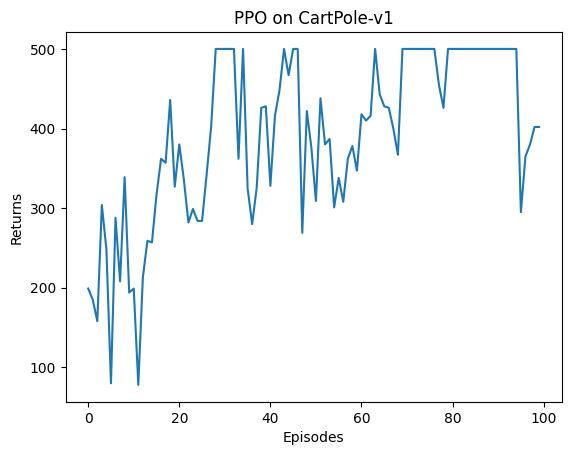

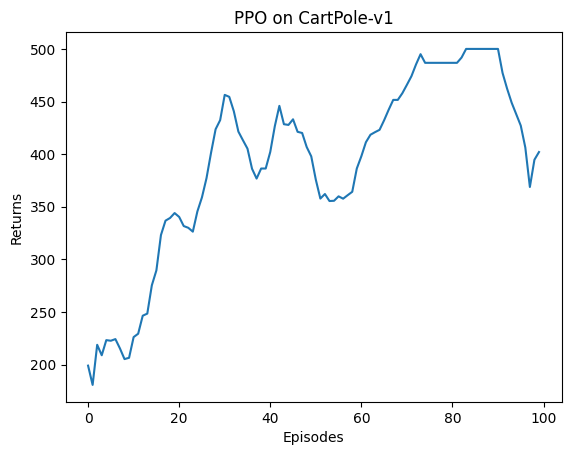

: 

In [ ]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()